# Probabilistic Roadmap


In this notebook you'll expand on previous random sampling exercises by creating a graph from the points and running A*.

1. Load the obstacle map data
2. Sample nodes (use KDTrees here)
3. Connect nodes (use KDTrees here)
4. Visualize graph
5. Define heuristic
6. Define search method
7. Execute and visualize

We'll load the data for you and provide a template for visualization.

In [1]:
# Again, ugly but we need the latest version of networkx!
# This sometimes fails for unknown reasons, please just 
# "reset and clear output" from the "Kernel" menu above 
# and try again!
import sys
#!{sys.executable} -m pip install -I networkx==2.1
import pkg_resources
pkg_resources.require("networkx==2.1")
import networkx as nx

In [2]:
nx.__version__ # should be 2.1

'2.1'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from sklearn.neighbors import KDTree
from queue import PriorityQueue

%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = 14, 14

In [5]:
altitude_max = 20
safety_distance = 1
start_ne = (-100,  -100)
goal_ne = (500., 300.)
num_samples = 300

## Step 1 - Load Data

In [6]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders2.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


## Step 2 - Sample Points


You may want to limit the z-axis values.

In [7]:
# TODO: sample points randomly
# then use KDTree to find nearest neighbor polygon
# and test for collision


In [8]:
class Obstacle:
    def __init__(self, corners, height):
        self._polygon = Polygon(corners)
        self._height = height
    
    @property
    def centroid(self):
        return self._polygon.centroid.x, self._polygon.centroid.y
    
    @property
    def height(self):
        return self._height
    
    def contains(self, point):
        return point[2] <= self._height and self._polygon.contains(Point(point[0:2]))
    
    def crosses(self, line):
        return self._polygon.crosses(line)
        

In [9]:
def extract_polygons(data, safety_distance):

    polygons = []
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        
        north_min = north - d_north - safety_distance
        north_max = north + d_north + safety_distance
        east_min = east - d_east - safety_distance
        east_max = east + d_east + safety_distance
        corners = [(north_min, east_min), 
                   (north_min, east_max), 
                   (north_max, east_max), 
                   (north_max, east_min)]
        
        # Compute the height of the polygon
        height = alt + d_alt + safety_distance

        # Once you've defined corners, define polygons
        polygons.append(Obstacle(corners, height))

    return polygons

In [10]:
def random_sample(polygons, num_samples=300, zmin=0, zmax=10):
    xmin = np.min(data[:, 0] - data[:, 3])
    xmax = np.max(data[:, 0] + data[:, 3])
    ymin = np.min(data[:, 1] - data[:, 4])
    ymax = np.max(data[:, 1] + data[:, 4])

    xvals = np.random.uniform(xmin, xmax, num_samples)
    yvals = np.random.uniform(ymin, ymax, num_samples)
    zvals = np.random.uniform(zmin, zmax, num_samples)

    samples = np.array((xvals, yvals, zvals)).T
    polygon_centroids = np.array([p.centroid for p in polygons])
    tree = KDTree(polygon_centroids, metric='euclidean')
    
    valid_samples = []
    while len(valid_samples) < num_samples:
        x = np.random.uniform(xmin, xmax)
        y = np.random.uniform(ymin, ymax)
        z = np.random.uniform(zmin, zmax)
        point = np.array((x, y, z))
        _, idx = tree.query(point[0:2].reshape(1, -1))
        if not polygons[int(idx)].contains(point):
            valid_samples.append(point)
    
    return np.array(valid_samples)

In [11]:
polygons = extract_polygons(data, safety_distance)
nodes = random_sample(polygons, num_samples=num_samples, zmax=altitude_max)

## Step 3 - Connect Nodes

Now we have to connect the nodes. There are many ways they might be done, it's completely up to you. The only restriction being no edge connecting two nodes may pass through an obstacle.

NOTE: You can use `LineString()` from the `shapely` library to create a line. Additionally, `shapely` geometry objects have a method `.crosses` which return `True` if the geometries cross paths, for instance your `LineString()` with an obstacle `Polygon()`!

In [12]:
# TODO: connect nodes
# Suggested method
    # 1) cast nodes into a graph called "g" using networkx
    # 2) write a method "can_connect()" that:
        # casts two points as a shapely LineString() object
        # tests for collision with a shapely Polygon() object
        # returns True if connection is possible, False otherwise
    # 3) write a method "create_graph()" that:
        # defines a networkx graph as g = Graph()
        # defines a tree = KDTree(nodes)
        # test for connectivity between each node and 
            # k of it's nearest neighbors
        # if nodes are connectable, add an edge to graph
    # Iterate through all candidate nodes!

In [13]:
def can_connect(polygons, n1, n2):
    line = LineString((n1[0:2], n2[0:2]))
    for poly in polygons:
        if min(n1[2], n2[2]) < poly.height and poly.crosses(line):
            return False
    return True

In [14]:
from tqdm import tqdm
def create_graph(polygons, nodes, k=10):
    g = nx.Graph()
    tree = KDTree(nodes, metric='euclidean')
    for n1 in tqdm(nodes):
        _, idxs = tree.query(n1.reshape(1, -1), k=k)
        for n2 in nodes[idxs[0][1:]]:
            if can_connect(polygons, n1, n2):
                dist = np.linalg.norm(n2 - n1, ord=2)
                g.add_edge(tuple(n1), tuple(n2), weight=dist)         
    return g

g = create_graph(polygons, nodes)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [02:13<00:00,  2.24it/s]


## Step 4 - Visualize Graph

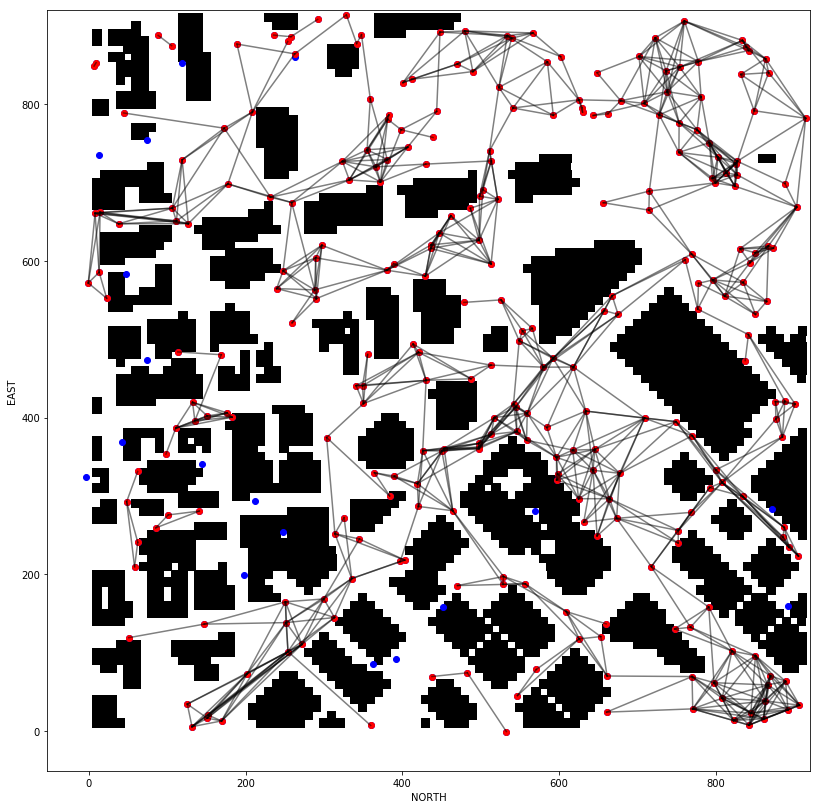

In [15]:
# Create a grid map of the world
from grid2 import create_grid
# This will create a grid map at 1 m above ground level
grid = create_grid(data, altitude_max, safety_distance)

fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)

# Draw all nodes connected or not in blue
for n1 in nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
    
# Draw connected nodes in red
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')

plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

## Step 5 - Define Heuristic

In [16]:
def heuristic(n1, n2):
    return np.linalg.norm(np.array(n2) - np.array(n1), ord=2)

## Step 6 - Complete A*

In [17]:
def a_star(graph, heuristic, start, goal):
    
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]

        if current_node == goal:        
            print('Found a path.')
            found = True
            break
            
        else:
            for next_node in graph[current_node]:
                # get the tuple representation
                cost = graph.edges[current_node, next_node]['weight']
                new_cost = current_cost + cost + heuristic(next_node, goal)  
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((new_cost, next_node))      
                    branch[next_node] = (new_cost, current_node)
    path = []
    path_cost = np.inf
    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
            
    return path[::-1], path_cost

## Step 7 - Visualize Path

Find the closest point in the graph to our current location, same thing for the goal location.

In [18]:
def closest_node(graph, point):
    nodes = np.array(graph.nodes)[:, 0:2]
    _, idx = KDTree(nodes, metric='euclidean').query(np.array(point).reshape(1, -1))
    return list(graph.nodes)[int(idx)]

start_node = closest_node(g, start_ne)
goal_node = closest_node(g, goal_ne)

Compute the path from the two points in the graph using the A* algorithm.

In [19]:
# Run A* on the graph
path, cost = a_star(g, heuristic, start_node, goal_node)
print('Cost: {}'.format(cost))

Found a path.
Cost: 4656.14711753801


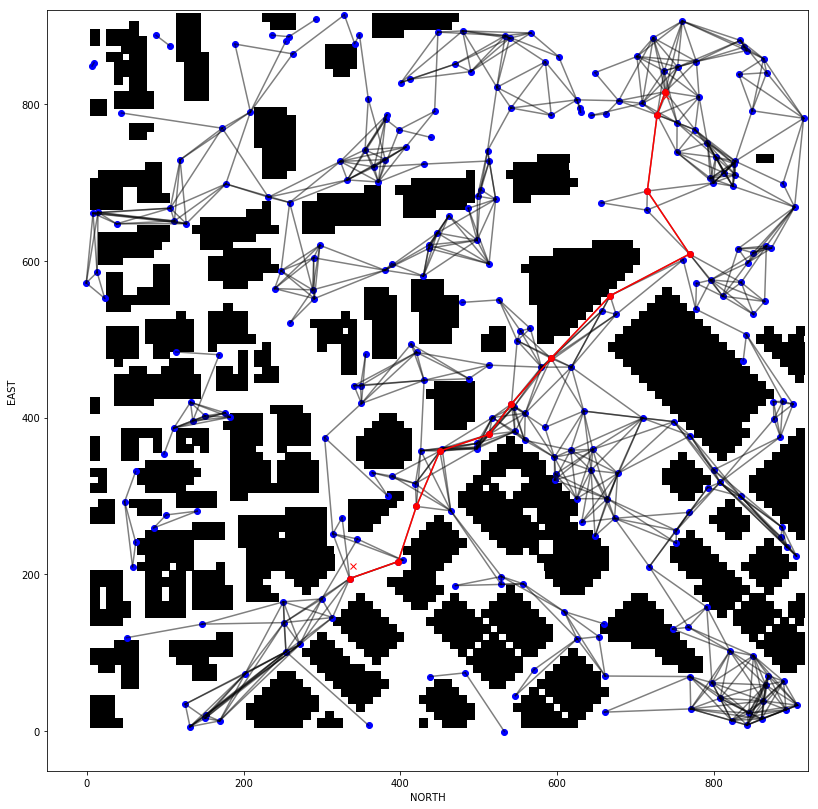

In [20]:
# Create a grid map of the world
from grid2 import create_grid
# This will create a grid map at 1 m above ground level
grid = create_grid(data, altitude_max, safety_distance)

fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)
    
# Draw connected nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
    
# Draw the path
path_2d = np.array(path)[:, 0:2] - np.array((nmin, emin))
plt.plot(path_2d[:, 1], path_2d[:, 0], 'ro-')

# plot start and goal
plt.plot(start_ne[1] - emin, start_ne[0] - nmin, 'rx')
plt.plot(goal_ne[1] - emin,  goal_ne[0] - nmin, 'rx')

plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()